# EMアルゴリズム

点推定を数値的に行う手法。ここでは特に最尤推定に着目する。

本資料は私が作成した下記資料を元に作られました。

https://gaussian-mixture.vercel.app

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
plt.style.use("ggplot")


---

## 潜在変数

観測データの裏に潜む、データをよく表した**観測できない**変数。

観測データの分布が複雑な時は、潜在変数を導入することで計算が簡単になる場合が多い。

潜在変数の導入とは、観測されたデータ$X=\{x^{(1)}, x^{(2)}, \cdots, x^{(N)}\}$の裏に潜在変数$Z=\{z^{(1)}, z^{(2)}, \cdots, z^{(N)}\}$が存在すると仮定し、それをモデル化すること。$x$に影響を与える何らかの確率変数を考え、それがどのように観測データに作用するかをモデル化するということ。

潜在変数の導入を数学的に表現すると、それは観測データと潜在変数の同時分布を定めることになる。

$$
p(x,z) = p(x|z)p(z)
$$

潜在変数の分布$p(z)$と、それがデータ$x$にどう作用するかを表す条件付き分布$p(x|z)$を定めている。ベイズ的に言うなら事前分布と尤度関数。

潜在変数を導入し、尤度を以下のように周辺化して表す。

$$
\begin{align}

p(x;\theta)
    &= \sum_z p(x,z;\theta) \\
    &= \sum_z p(x|z;\theta)p(z;\theta)

\end{align}
$$


---

## EMアルゴリズム

EMアルゴリズムの計算方法を見ていく。

まず対数尤度関数を考える。

$$
\begin{align}
    \log p(X;\theta)
        &= \log \prod_{i=1}^n p(x^{(i)};\theta) \\
        &= \sum_{i=1}^n \log p(x^{(i)};\theta) \\
\end{align}
$$

尤度$p(x^{(i)};\theta)$が複雑で、このまま進めても解が求められない場合を考えていく。

ここで潜在変数を導入する。

$$
p(X;\theta) = \sum_Z p(X,Z;\theta)
$$


では、この下で対数尤度を見ていく。

$$
\begin{align}
\log p(X;\theta)
    &= \log \sum_Z p(X,Z;\theta) \\
    &= \log \sum_Z q(Z) \frac{p(X,Z;\theta)}{q(Z)} \\
    &\ge \sum_Z q(Z) \log \frac{p(X,Z;\theta)}{q(Z)} \\
    &= \mathcal{L}(q(Z),\theta)
\end{align}
$$

途中の不等式は**イェンゼンの不等式**というもの。$q(Z)$はイェンゼンの不等式を使うために適当に持ち出したなんらかの確率分布。現時点では明確になっていない。  

最後に出てきた式は下界と呼び、$\mathcal{L}(q(Z),\theta)$と置いた。エビデンス（対数尤度）の下界ということで、ELBO（Evidence lower bound）とも呼ぶ。変分ベイズでも出てくるので、変分下界（Variational Lower Bound）とも呼ぶ。

ここで、対数尤度関数と下限の差を求めると

$$
\begin{align}

& \log p(X; \theta) - \mathcal{L}(q(Z), \theta) \\

&\quad = \log p(X; \theta) - \sum_Z q(Z) \log \frac{p(X, Z; \theta)}{q(Z)} \\

&\quad = \sum_Z q(Z)\log p(X; \theta) - \sum_Z q(Z) \log \frac{p(X| Z; \theta)p(Z; \theta)}{q(Z)} \\

&\quad = \sum_Z q(Z) \Big( \log p(X; \theta) - \log p(X| Z; \theta) - \log p(Z; \theta) + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( -\log \frac{p(X| Z; \theta)p(Z; \theta)}{p(X; \theta)} + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( -\log p(Z| X; \theta) + \log q(Z) \Big) \\

&\quad = \sum_Z q(Z) \Big( \log \frac{q(Z)}{p(Z| X; \theta)} \Big) \\

&\quad = D_{KL}[q(Z) || p(Z| X; \theta)] 

\end{align}
$$

$q(Z)$と$p(Z|X,\theta)$の KL ダイバージェンスになる。KLダイバージェンスは二つの確率分布の近さを表す指標として知られる。

これを以下のようにまとめる。 

$$
\begin{align}

\log p(X; \theta) = \mathcal{L}(q(Z), \theta) + D_{KL}[q(Z) || p(Z| X; \theta)]

\end{align}
$$

対数尤度をKLダイバージェンスと下界の和で表すことが出来た。

我々はこれを最大化したい。ここで思いつくのは、下界とKLダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。

真っ先に思いつくのは、下限と KL ダイバージェンスを別々に最大化する方法である。そうすれば対数尤度も大きくなりそう。しかし、このやり方は上手くいかない。なぜかな。

まず、我々が自由に操作できる変数は以下の二つである。

- $\theta$
- $q(Z)$

この二つの変数を対数尤度が最大になるように設定したい訳だが、実は対数尤度は$q(Z)$に依存しない。したがって、$q(Z)$をいじった時に変わるものは対数尤度ではなく、下限と KL ダイバージェンスの比率である。どちらかを大きくする$q(Z)$は、もう一方を小さくする$q(Z)$となる。


ではどうすべきか。正解は以下。

1. $\theta$を初期化する。
2. $\theta$を固定し、KL ダイバージェンスを最小化する。
3. $q(Z)$を固定し、下限を最大化する。
4. 2, 3 を繰り返す。


まずは$\theta$の初期化だがこれは何でもよい。とりあえず$\theta^{\text{old}}$と表記しておく。

次に、その$\theta^{\text{old}}$の下でKLダイバージェンスを最小化する。つまり$D_{KL}[q(Z) || p(Z| X; \theta^{\text{old}})]=0$となる$q(Z)$を求める。 ここで、KLダイバージェンスは二つの確率分布が完全に一致する際に唯一の0をとる。ということで、$q(Z) = p(Z| X; \theta^{\text{old}})$とする。

では今度はその$q(Z)$を固定して下限を最大化する。つまり以下を行う。

$$
\begin{align}

\theta^{\text{new}} = \argmax_\theta \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta)

\end{align}
$$

ここで下限を少し整理する。

$$
\begin{align}

\mathcal L (p(Z| X; \theta^{\text{old}}),\theta)

&= \sum_Z p(Z| X; \theta^{\text{old}}) \log \frac{p(X, Z; \theta)}{p(Z| X; \theta^{\text{old}})} \\

&= \sum_Z p(Z|X;\theta^{old}) \log p(X, Z; \theta) + \mathrm{const} \\

&= \mathbb E_{p(Z| X; \theta^{\text{old}})} \big[ \log p(X, Z; \theta) \big] + \mathrm{const} \\

&= \mathcal Q (\theta| \theta^{\text{old}}) + \mathrm{const}

\end{align}
$$

事後分布に関する同時分布の対数尤度の期待値になった。これは$\mathcal Q(\theta, \theta_{\text{old}})$と表しておく。この期待値を最大にする$\theta$を求め、それを新たな$\theta$とする。この期待値はsum-logの形になっており、解析的に解きやすい。

\begin{align}

\theta^{\text{new}} = \argmax_{\theta} \mathcal Q(\theta, \theta^{\text{old}})

\end{align}


そして$\theta^{\text{old}} := \theta^{\text{new}}$として、同じように期待値を最大化する。これを繰り返すことで、対数尤度を大きくすることができる。

ということで、EMアルゴリズムの流れは以下。

1. 潜在変数の導入
2. パラメータ$\theta^{\text{old}}$の初期化
3. 同時分布の期待値の最大化:
    - $\theta^{\text{new}} \larr \argmax_\theta \mathcal Q(\theta|\theta^{\text{old}})$
    - $\theta^{\text{old}} \larr \theta^{\text{new}}$
4. 3を繰り返す

期待値（*Expected value*）の最大化（*Maximization*）を繰り返すため、EM アルゴリズムと呼ばれる。また、数学的には期待値を求めるステップと最大化のステップに分けられ、それぞれEステップ・Mステップと呼ばれたりする。

### 対数尤度が単調増加することの証明

以下を示す。

$$
\begin{align}

\log p(X; \theta^{\text{new}}) \geq \log p(X; \theta^{\text{old}})

\end{align}
$$

$q(Z) = p(Z| X; \theta)$であるとき、対数尤度と下界は一致する。よって

$$
\begin{align}

\log p(X; \theta^{\text{old}}) = \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}})

\end{align}
$$

ここで、

$$
\begin{align}

\theta^{\text{new}} = \argmax_\theta \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta)

\end{align}
$$

より、

$$
\begin{align}

\mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}}) \geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}})

\end{align}
$$

が成り立つ。

が成り立つ。また、任意の$q(Z)$で

$$
\begin{align}

\log p(X; \theta) \geq \mathcal{L}(p(Z), \theta)

\end{align}
$$

が成り立つので、

$$
\begin{align}

\log p(X; \theta^{\text{new}}) \geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}})

\end{align}
$$

が成り立つ。よって

$$
\begin{align}

\log p(X; \theta^{\text{new}}) 

&\geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{new}}) \\

&\geq \mathcal{L}(p(Z| X; \theta^{\text{old}}), \theta^{\text{old}}) \\

&= \log p(X; \theta^{\text{old}})

\end{align}
$$

が成り立つ。証明終わり。

なお、ここで示したのは対数尤度が単調増加することで、パラメータが最適解に収束することではない。いわゆる局所解に陥るといった状況はEMアルゴリズムでも起こり得るので、初期値依存の手法ではある。


---

## 混合ガウス分布

*Gaussian Mixture*

複数のガウス分布を足し合わせた分布。多峰性が見られる分布に適用する。この分布の最尤推定にEMアルゴリズムが適用できるので、実際にやってみる。

$$
\begin{align}

p(x; \theta) = \sum_{k=1}^K \pi_k \mathcal N_k(x)

\end{align}
$$

- $\mathcal N_k (x) = \mathcal N( x; \mu_k, \sigma_k^2)$
- $\pi_k\in[0,1] \quad \sum_k \pi_k = 1$

$K$個のガウス分布$\mathcal N_1, \mathcal N_2, \cdots, \mathcal N_K$と混合比率$\pi_1, \pi_2, \cdots, \pi_K$の重み付き和で表される。

各ガウス分布のパラメータ$\mu_k,\sigma_k^2$と混合比率$\pi_k$がパラメータとなる。

この分布の対数尤度は以下。

$$

\begin{align}

\log p(x; \theta) = \log \left( \sum_{k=1}^K \pi_k \mathcal N_k(x) \right)

\end{align}

$$

log-sumと呼ばれる$\log$の中に$\sum$が入る形になった。この形は非常に厄介で、解析的に解を得られないことが知られている。ということで、普通には解けないので、EMアルゴリズムで数値的に解く。

### 潜在変数

潜在変数として、サンプル$x^{(n)}$がどのガウス分布から生成されたかを表す$z^{(n)}\in\{1,2,\cdots,K\}$を導入する。

こうすると、事前分布はクラス数$K$個のカテゴリカル分布となる。

$$
\begin{align}

p(z = k) = \pi_k

\end{align}
$$

次に尤度関数だが、各クラスに対応するガウス分布となる。

$$
\begin{align}

p(x| z = k; \theta)

&= \mathcal N_k(x)

\end{align}
$$

てことで、同時分布は以下。

$$
\begin{align}

p(x, z = k; \theta)
  &= p(x| z = k; \theta)p(z = k; \theta) \\
  &= \mathcal N_{k}(x) \pi_k
\end{align}
$$

これを周辺化すると、元の分布と一致するね。

$$
\begin{align}

\sum_{z=1}^K p(x, z; \theta) = \sum_{k=1}^K \pi_k \mathcal N_k(x)

\end{align}
$$

### Eステップ

同時分布の期待値を求める。

$$
\begin{align}

\mathcal Q(\theta, \theta^{\text{old}})

&= \mathbb E_{p(Z|X;\theta^{\text{old}})} [ \, \log p(X, Z; \theta) \, ] \\

&= \mathbb E_{p(Z|X;\theta^{\text{old}})} \left[ \sum_i \log p(x^{(i)}, z^{(i)}; \theta) \right] \\

&= \sum_i \mathbb E_{p(z| x^{(i)}; \theta^{\text{old}})} \left[ \, \log p(x^{(i)}, z; \theta) \, \right] \\

&= \sum_i \mathbb E_{p(z| x^{(i)}; \theta^{\text{old}})} \left[ \, \log \mathcal N_z (x^{(i)}) + \log \pi_z \, \right] \\

&= \sum_i \sum_k p(z=k| x^{(i)}; \theta^{\text{old}}) \left( \log \mathcal N_k(x^{(i)}) + \log \pi_k \right) \\

&= \sum_i \sum_k \gamma_k^{(i)} \left( \log \mathcal N(\boldsymbol x^{(i)}; \boldsymbol\mu_k, \Sigma_k) + \log \pi_k \right) \\

&= \sum_i \sum_k \gamma_k^{(i)} \left( -\frac{1}{2} \Big( d \log(2\pi) + \log |\Sigma|_k + (\boldsymbol x^{(i)} - \boldsymbol\mu_k)^T \Sigma_k^{-1} (\boldsymbol x^{(i)} - \boldsymbol\mu_k) \Big) + \log \pi_k \right) \\

\end{align}
$$

事後確率は$\gamma_k^{(i)}$とおき、これは負担率と呼ぶ。

$$
\begin{align}

\gamma_k^{(i)}

&= p(z = k| x^{(i)}, \theta^{\text{old}}) \\

&= \frac{p(x^{(i)}| z = k; \theta^{\text{old}})p(z = k; \theta^{\text{old}})}{p(x^{(i)}; \theta^{\text{old}})} \\

&= \frac{\pi_k^{\text{old}}\mathcal N(x^{(i)}; \mu_k^{\text{old}}, \Sigma_k^{\text{old}})}{\sum_k \pi_k^{\text{old}}\mathcal N(x^{(i)}; \mu_k^{\text{old}}, \Sigma_k^{\text{old}})}

\end{align}
$$

### Mステップ

期待値を最大化するパラメータを偏微分で求める。

ここで、負担率の和を$N_k$とおいておく。

$$
\begin{align}

N_k = \sum_n \gamma_k^{(n)}

\end{align}
$$

#### $\boldsymbol\mu_k$

まず$\boldsymbol\mu_k$。

まず偏微分。

$$
\begin{align}

\frac{\partial \mathcal Q}{\partial \boldsymbol\mu_k}

&= -\frac{1}{2} \sum_n \gamma_k^{(n)} \frac{\partial}{\partial \boldsymbol\mu_k}(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T \Sigma^{-1} (\boldsymbol x^{(n)} - \boldsymbol\mu_k) \\

&= - \Sigma_k^{-1} \sum_n \gamma_k^{(n)} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)

\end{align}
$$

0になる点を求める。

$$
\begin{align}

- \Sigma_k^{-1} \sum_n \gamma_k^{(i)} (\boldsymbol x^{(n)} - \boldsymbol\mu_k) &= 0 \\

\frac{1}{N_k} \sum_n \gamma_k^{(n)} \boldsymbol x^{(n)} &= \boldsymbol\mu_k \\

\end{align}
$$

#### $\Sigma_k$

次、$\Sigma_k$。

偏微分。

$$
\begin{align}

\frac{\partial \mathcal Q}{\partial \Sigma_k}

&= -\frac{1}{2} \sum_n \gamma_k^{(n)} \frac{\partial}{\partial \Sigma_k} \Big(\log |\Sigma_k| + (\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T \Sigma_k^{-1} (\boldsymbol x^{(n)} - \boldsymbol\mu_k) \Big) \\

&= -\frac{1}{2} \sum_n \gamma_k^{(n)} \Big(\Sigma_k^{-1} - \Sigma_k^{-1} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T\Sigma_k^{-1}  \Big) \\

\end{align}
$$

0になる点を求める。

$$
\begin{align}

-\frac{1}{2} \sum_n \gamma_k^{(n)} \Big( \Sigma_k^{-1} - \Sigma_k^{-1} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T\Sigma_k^{-1}  \Big) &= 0 \\

\frac{1}{N_k} \sum_n r_k^{(n)} \Sigma_k^{-1} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T\Sigma_k^{-1} &= \Sigma_k^{-1} \\

\frac{1}{N_k} \sum_n r_k^{(n)} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T &= \Sigma_k

\end{align}
$$

#### $\pi_k$

最後、$\pi_k$。

$\pi_k$は他のパラメータと違い、制約条件がある。

$$
\begin{align}

g(\pi_k) = \sum_{k'} \pi_{k'} - 1 = 0

\end{align}
$$

ラグランジュの未定乗数法を使おう。

$$
\begin{align}

\frac{\partial(\mathcal Q + \lambda g(\pi_k))}{\partial \pi_k} 

&= -\frac{1}{2} \sum_n \gamma_k^{(n)} \frac{\partial}{\partial\pi_k} \Big( \log \pi_k + \lambda \Big( \sum_{k'} \pi_{k'} - 1 \Big) \Big) \\

&= \sum_n \gamma_k^{(n)} \Big( \frac{1}{\pi_k} + \lambda \Big)

\end{align}
$$

0になる点を求める。

$$
\begin{align}

\sum_n \gamma_k^{(n)} \Big( \frac{1}{\pi_k} + \lambda \Big) &= 0 \\

-\sum_n \gamma_k^{(n)} &= \lambda\pi_k\\

\end{align}
$$

ここで、両辺で$k$について総和を取り、

$$
\begin{align}

-\sum_k\sum_n \gamma_k^{(n)}
&= \sum_k\lambda\pi_k \\
-N &= \lambda

\end{align}
$$

これを代入する

$$
\begin{align}

-\sum_n \gamma_k^{(n)} &= -N\pi_k \\

\frac{1}{N} \sum_n \gamma_k^{(n)} &= \pi_k \\

\end{align}
$$

これで全ての解が得られた。

#### まとめ

$$
\begin{align}

\boldsymbol\mu_k &= \frac{1}{N_k} \sum_n \gamma_k^{(n)} \boldsymbol x^{(n)} \\

\Sigma_k &= \frac{1}{N_k} \sum_n \gamma_k^{(n)} (\boldsymbol x^{(n)} - \boldsymbol\mu_k)(\boldsymbol x^{(n)} - \boldsymbol\mu_k)^T \\

\pi_k &= \frac{N_k}{N}

\end{align}
$$

$\boldsymbol\mu_k, \Sigma_k$は通常のガウス分布の最尤推定量とほぼ同じ形だが、普通の平均ではなく、負担率の加重平均になっている。

### 実装

実装してみよう。以下のデータに対して混合ガウス分布を仮定し、EMアルゴリズムでパラメータを推定する。

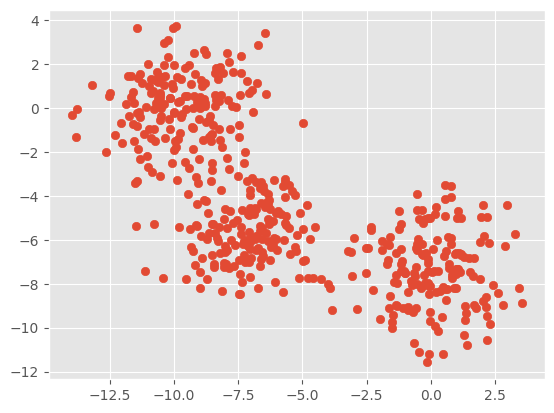

In [2]:
from sklearn.datasets import make_blobs

N = 500
d = 2
K = 3

X, y = make_blobs(
    n_samples=N,
    n_features=d,
    centers=K,
    cluster_std=1.5,
    random_state=9,
)
plt.scatter(X[:, 0], X[:, 1]);

まずパラメータを初期化する。ちなみに$K=3$。なんとなく峰が3つあるように見えるでしょ。実際に`K=3`としてこのサンプルデータを生成しているからね。

In [3]:
mu = np.random.randn(K, d)
sigma = np.tile(np.eye(d), (K, 1, 1))
pi = np.ones(K) / K
print("mu shape:", mu.shape) # (K, d)
print("sigma shape:", sigma.shape) # (K, d, d)
print("pi shape:", pi.shape) # (K,)

mu shape: (3, 2)
sigma shape: (3, 2, 2)
pi shape: (3,)


全てのガウス分布$\mathcal N_k$のパラメータを一つの変数にまとめた。$\Sigma_k$は単位行列、$\pi$は一様分布で初期化した。$\boldsymbol\mu_k$だけは乱数で初期化しており、こうしないと（全ての$\boldsymbol\mu_k$が同じ値だと）学習が上手くいかない。

次は事後確率を求める。負担率$\gamma_k^{(n)}$を求める。Eステップ。ここは繰り返すので関数にしておく。

In [4]:
def posterior(X, mu, sigma, pi):
    joint_probs = []
    for mu, sigma, pi in zip(mu, sigma, pi):
        norm = sp.stats.multivariate_normal(mean=mu, cov=sigma)
        likelihood = norm.pdf(X)
        joint_prob = pi * likelihood
        joint_probs.append(joint_prob)
    joint_probs = np.array(joint_probs)
    gamma = joint_probs / joint_probs.sum(axis=0) # (K, N)
    return gamma

最後にMステップ。負担率を元にパラメータを更新する。指定した回数繰り返してみよう。

In [5]:
n_iter = 100
for _ in range(n_iter):
    gamma = posterior(X, mu, sigma, pi)
    Nk = gamma.sum(axis=1)

    mu = gamma @ X / Nk.reshape(-1, 1)

    for i in range(K):
        sigma[i] = gamma[i] * (X - mu[i]).T @ (X - mu[i]) / Nk[i]

    pi = Nk / N

彫られたパラメータを元に、混合ガウス分布を描画してみる。

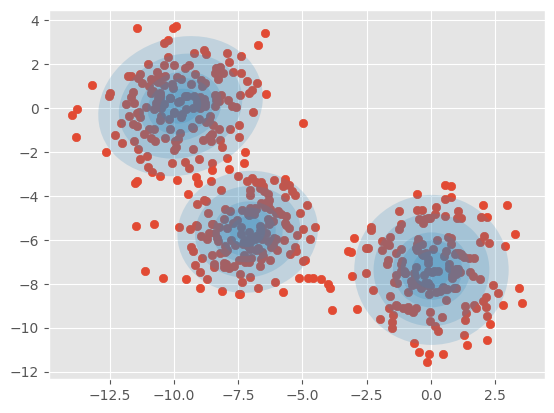

In [6]:
from matplotlib.patches import Ellipse
C = 3
fig, ax = plt.subplots()
ax.scatter(X[:, 0], X[:, 1])
for i in range(K):
    U, (vx, vy), _ = np.linalg.svd(sigma[i])
    angle = np.degrees(np.arctan2(U[0, 1], U[0, 0])) # 第一主成分軸の角度
    for r in [0.5, 0.8, 1., 1.5, 2.]:
        w = 2 * np.sqrt(vx) * r * pi[i] * C
        h = 2 * np.sqrt(vy) * r * pi[i] * C
        ellipse = Ellipse(mu[i], w, h, angle=angle, alpha=0.2)
        ax.add_artist(ellipse)

いい感じにフィットしている。